In [5]:
import tensorflow as tf
import ctc_utils
import cv2
import numpy as np
import tensorflow.compat.v1 as tf_v1
import numpy as np
from primus import CTC_PriMuS

tf.compat.v1.disable_eager_execution()


In [6]:
SEMANTIC = ''

model = "Models/semantic_model.meta"
voc_file = "Data/vocabulary_semantic.txt"

tf_v1.reset_default_graph()
sess = tf_v1.InteractiveSession()


In [7]:
# Read the dictionary
dict_file = open(voc_file,'r')
dict_list = dict_file.read().splitlines()
int2word = dict()
for word in dict_list:
    word_idx = len(int2word)
    int2word[word_idx] = word
dict_file.close()

In [8]:
# Restore weights
saver = tf_v1.train.import_meta_graph(model)
saver.restore(sess,model[:-5])

graph = tf_v1.get_default_graph()

input = graph.get_tensor_by_name("model_input:0")
seq_len = graph.get_tensor_by_name("seq_lengths:0")
rnn_keep_prob = graph.get_tensor_by_name("keep_prob:0")
height_tensor = graph.get_tensor_by_name("input_height:0")
width_reduction_tensor = graph.get_tensor_by_name("width_reduction:0")
logits = tf_v1.get_collection("logits")[0]

# Constants that are saved inside the model itself
WIDTH_REDUCTION, HEIGHT = sess.run([width_reduction_tensor, height_tensor])

decoded, _ = tf_v1.nn.ctc_greedy_decoder(logits, seq_len)


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from Models/semantic_model


In [9]:
test_file = open("Data/test.txt",'r')
test_list = test_file.read().splitlines()
test_file.close()

In [12]:
# Taking only N number of testing data

import random

random.shuffle(test_list)
test_n_list = test_list[0:100]
print(len(test_n_list))

100


In [30]:
# Getting the test data's ground truth
from collections import Counter
import math

data_dirpath = "D:/3.Projects/Major Project/OMR/downloaded/primusCalvoRizoAppliedSciences2018/extractedOneDir"

sample_no = []
acc = []
i = 0
accuracy_list = []

def counter_cosine_similarity(c1, c2):
        terms = set(c1).union(c2)
        dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
        magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
        magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
        return dotprod / (magA * magB)

for test_filepath in test_list:

    i += 1

    # Making a full filepath
    fullpath = data_dirpath + '/' + test_filepath + '/' + test_filepath
    image = cv2.imread(fullpath + '.png', 0)  # Grayscale is assumed!
    gt_filepath = fullpath + '.semantic'

    # Converting GT to list of symbols
    gt_file = open(gt_filepath, 'r')
    sample_gt_plain = gt_file.readline().rstrip().split(ctc_utils.word_separator())

    #predictions
    image = ctc_utils.resize(image, HEIGHT)
    image = ctc_utils.normalize(image)
    image = np.asarray(image).reshape(1,image.shape[0],-1,1)

    seq_lengths = [ image.shape[2] / WIDTH_REDUCTION ]

    prediction = sess.run(decoded,
                      feed_dict={
                          input: image,
                          seq_len: seq_lengths,
                          rnn_keep_prob: 1.0,
                      })

    str_predictions = ctc_utils.sparse_tensor_to_strs(prediction)

    SEMANTIC = []
    for w in str_predictions[0]:
        SEMANTIC.append(int2word[w])

    counterA = Counter(sample_gt_plain)
    counterB = Counter(SEMANTIC)

    accuracy_list.append(counter_cosine_similarity(counterA, counterB) * 100)

    if (i%100 == 0):
        avg_accu = sum(accuracy_list)/100
        accuracy_list.clear()
        
        sample_no.append(i)
        acc.append(round(avg_accu, 2))

        print("Accuracy for", int(i/100), "100 data =",  round(avg_accu, 2))

Accuracy for 1 100 data = 97.79
Accuracy for 2 100 data = 98.67
Accuracy for 3 100 data = 98.8
Accuracy for 4 100 data = 98.86
Accuracy for 5 100 data = 98.45
Accuracy for 6 100 data = 98.64
Accuracy for 7 100 data = 98.41
Accuracy for 8 100 data = 98.69
Accuracy for 9 100 data = 98.88
Accuracy for 10 100 data = 97.89
Accuracy for 11 100 data = 98.73
Accuracy for 12 100 data = 99.18
Accuracy for 13 100 data = 97.65
Accuracy for 14 100 data = 97.87
Accuracy for 15 100 data = 97.59
Accuracy for 16 100 data = 98.66
Accuracy for 17 100 data = 98.68
Accuracy for 18 100 data = 99.18
Accuracy for 19 100 data = 97.97
Accuracy for 20 100 data = 98.53
Accuracy for 21 100 data = 98.53
Accuracy for 22 100 data = 98.82
Accuracy for 23 100 data = 98.85
Accuracy for 24 100 data = 98.66
Accuracy for 25 100 data = 98.58
Accuracy for 26 100 data = 98.05
Accuracy for 27 100 data = 98.6
Accuracy for 28 100 data = 98.02
Accuracy for 29 100 data = 98.77
Accuracy for 30 100 data = 98.62
Accuracy for 31 100 d

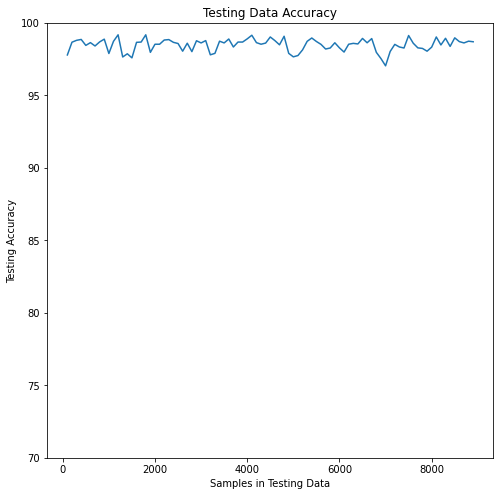

In [31]:
#plotting the accuracy graph

import matplotlib.pyplot as plt

plt.figure(figsize = (8,8))
plt.plot(sample_no, acc)
plt.xlabel("Samples in Testing Data")
plt.ylabel("Testing Accuracy")
plt.ylim(70, 100)
plt.title("Testing Data Accuracy")
plt.show()


In [33]:
average_acc = sum(acc)/89
print(average_acc)

98.48393258426967
